In [2]:
import pandas as pd
import numpy as np
from snownlp import SnowNLP
import jieba
import pyLDAvis.gensim
import wordcloud
import os, codecs
import jieba.posseg as pseg
import matplotlib.pyplot as plt
from collections import Counter
from pylab import mpl
from gensim import corpora,models
import seaborn as sns

In [3]:
df=pd.read_csv('F:/在线评论数据2差评.csv')
df1= df['text']

In [4]:
#查询重复值
df1.duplicated().value_counts() 
#处理重复值
df2= df1.drop_duplicates()
df2.duplicated().value_counts() 
#去除短句，保留长度大于5的数据
df3 = df2[df2.str.len()>5]
df3 = df3.reset_index(drop=True)
data =df3.tolist()

In [5]:
def load_stopword():
    '''
    加载停用词表
    :return: 返回停用词的列表
    '''
    f_stop = open('F://stopWord.txt','r',encoding='UTF-8')
    sw = [line.strip() for line in f_stop]
    f_stop.close()
    sw.append('\n')
    return sw

In [6]:
stopwords = load_stopword()
#自定义字典
jieba.load_userdict("F://dict.txt")
text_list = []
cloud_text = ''
c = Counter()
for i in range(len(df3)):
    seg_list = jieba.posseg.cut(df3[i])
    mytext_list=[]
    for x in seg_list:
        if len(x.word)>1 and x.word != '\r\n' and x.word not in stopwords :#  and x.flag =='n':
            c[x.word] += 1
            mytext_list.append(x.word.replace(" ",""))
    text_list.append(mytext_list)
    cloud_text+=",".join(mytext_list)
print('词频度统计结果')
for (k,v) in c.most_common(50):
    print('{}:{}'.format(k,v))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\59433\AppData\Local\Temp\jieba.cache
Loading model cost 0.924 seconds.
Prefix dict has been built successfully.


词频度统计结果
门票:109
感觉:37
值得:33
小时:31
建议:29
根本:29
门口:28
游客:27
知道:27
没什么:27
不好:26
工作人员:25
不值:23
体验:21
买票:21
收费:21
不错:20
时间:20
照片:19
网上:19
东西:19
景色:19
管理:18
电话:18
最后:18
完全:18
推荐:18
失望:17
特别:17
免费:17
建筑:17
垃圾:17
演出:16
所谓:16
朋友:16
进入:16
服务:16
需要:16
只能:15
项目:15
平遥:14
导游:14
介绍:14
参观:14
实在:14
整个:14
游玩:14
孩子:14
告诉:13
现在:13


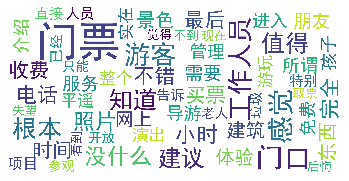

In [8]:
#创建词云
font = "C:\\Windows\\Fonts\\simhei.TTF"#词云的中文字体所在路径
wc = wordcloud.WordCloud(
    scale = 7,
    background_color="white", #背景颜色
    #max_words=200, #显示最大词数
    font_path=font,
    min_font_size=15,
    max_font_size=50, 
    width=400  #图幅宽度
    )
wc.generate(cloud_text)

plt.imshow(wc)
plt.axis("off")
plt.show()

In [9]:
# 主题分析
text_dict = corpora.Dictionary(text_list) # 创建语料的词语词典，每个单独的词语都会被赋予一个索引
text_corpus = [text_dict.doc2bow(i) for i in text_list] # 使用上面的词典，将转换文档列表（语料）变成 DT 矩阵
tfidf = models.TfidfModel(text_corpus)
corpus_tfidf = tfidf[text_corpus]

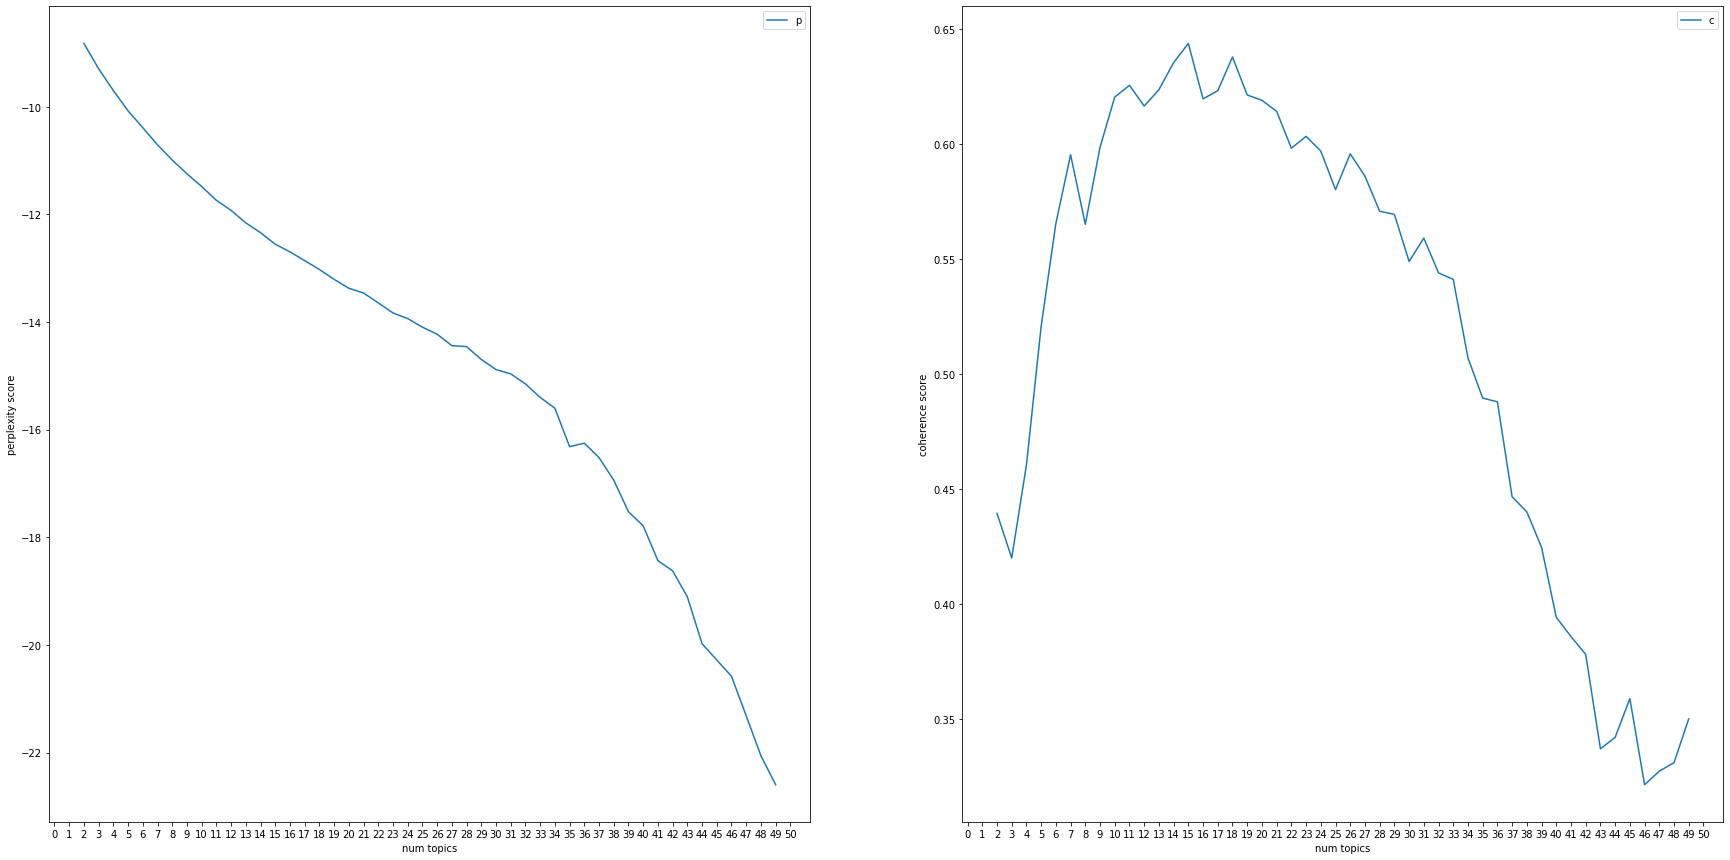

In [14]:
#困惑度 一致度
x_list = []
y_plist =[]
y_clist =[] 
for i in range(2,50):
    text_lda = models.LdaModel(corpus_tfidf,num_topics = i,id2word =text_dict ) # LDA模型训练
    perplexity = text_lda.log_perplexity(corpus_tfidf)
    cv_tmp = models.CoherenceModel(model=text_lda,texts=text_list, dictionary=text_dict, coherence='c_v')
    x_list.append(i)
    y_plist.append(perplexity)
    y_clist.append(cv_tmp.get_coherence())
    
plt.figure(figsize=(30,15))    
plt.subplot(1,2,1)
plt.plot(x_list,y_plist)
plt.xticks(np.linspace(0, 50, 51))
plt.xlabel('num topics')
plt.ylabel('perplexity score')
plt.legend(('perplexity_values'), loc='best')

plt.subplot(1,2,2)
plt.plot(x_list,y_clist)
plt.xticks(np.linspace(0, 50, 51))
plt.xlabel('num topics')
plt.ylabel('coherence score')
plt.legend(('coherence_values'), loc='best')

plt.show()

In [12]:
lda = models.LdaModel(text_corpus,num_topics =15,id2word =text_dict ) # LDA模型训练
for i in range(15):
    print('topic' + str(i))
    print(lda.print_topic(i)) # 输出每个主题

topic0
0.011*"游客" + 0.008*"门票" + 0.007*"没什么" + 0.007*"知道" + 0.007*"参观" + 0.006*"后悔" + 0.006*"块钱" + 0.006*"马车" + 0.006*"感觉" + 0.006*"值得"
topic1
0.011*"整个" + 0.007*"所谓" + 0.007*"特色" + 0.006*"门票" + 0.006*"介绍" + 0.006*"没什么" + 0.006*"银饰" + 0.005*"小伙伴" + 0.005*"进园" + 0.005*"酒店"
topic2
0.015*"门票" + 0.012*"没什么" + 0.010*"值得" + 0.009*"门口" + 0.008*"游客" + 0.006*"推荐" + 0.006*"不好" + 0.006*"根本" + 0.006*"小时" + 0.005*"20"
topic3
0.008*"不错" + 0.008*"游客" + 0.008*"项目" + 0.005*"体验" + 0.005*"垃圾" + 0.005*"出口" + 0.005*"停车费" + 0.005*"停车场" + 0.005*"描述" + 0.005*"环境"
topic4
0.018*"不好" + 0.006*"失望" + 0.006*"东西" + 0.006*"门票" + 0.005*"管理" + 0.005*"差差" + 0.005*"去过" + 0.004*"老人" + 0.004*"门口" + 0.004*"参观"
topic5
0.012*"不值" + 0.009*"工作人员" + 0.008*"现在" + 0.008*"门票" + 0.006*"设施" + 0.006*"不好玩" + 0.006*"买票" + 0.006*"免费" + 0.006*"小朋友" + 0.006*"植物"
topic6
0.025*"门票" + 0.012*"免费" + 0.010*"建议" + 0.008*"宠物" + 0.008*"小时" + 0.007*"购买" + 0.007*"根本" + 0.007*"学生票" + 0.006*"应该" + 0.006*"买票"
topic7
0.038*"门票" + 0.008*"值得" + 0.006*"电话" 

In [14]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

# Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
# Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

# Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [15]:
#文档中贡献百分比最高的主题
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=text_corpus, texts=data)# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']# Show
df_dominant_topic.head(10)
#df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9417,"不错, 游客, 项目, 体验, 垃圾, 出口, 停车费, 停车场, 描述, 环境",商业化太浓，遭遇无良商家，西江阿仰银楼客栈，为了赚高价不惜临时毁约，损害游客利益。
1,1,10.0,0.9922,"打球, 感觉, 旁边, 知道, 派出所, 孩子, 失望, 后面, 实在, 以后",西江千户苗寨真是让人极端失望的景点。人在这里连最基本的安全体验都非常差，演出场旁边就是路边就...
2,2,5.0,0.8133,"不值, 工作人员, 现在, 门票, 设施, 不好玩, 买票, 免费, 小朋友, 植物",没啥可看的，9个里面最差景点，如果不够买联票，可以不去
3,3,7.0,0.6888,"门票, 值得, 电话, 不值, 知道, 没什么, 不用, 建议, 工作人员, 告诉",差评服务态度，现役军人不能进。
4,4,14.0,0.9733,"体验, 项目, 门票, 感觉, 很差, 所谓, 买票, 管理, 值得, 停车场",我们提前在携程上付款订好的，到剧场门口之后给携程打电话跟我们说没票了，然后说没办法，携程的那...
5,5,4.0,0.9678,"不好, 失望, 东西, 门票, 管理, 差差, 去过, 老人, 门口, 参观",首先，表演不错，为什么给差评，第一，因为有个什么电影节，平时七点的场改八点，结果八点没有开始...
6,6,8.0,0.9741,"感觉, 门票, 推荐, 完全, 售票, 建议, 体验, 最后, 中心, 二维码",建议到售票中心购买，只贵十块钱。如果通过携程定，到了叫我等，说是给送到售票中心旁边的小树林，...
7,7,12.0,0.9151,"门票, 工作人员, 根本, 网上, 丽江古城, 最后, 导游, 只能, 窗口, 不到",携程携所谓的经销商价格欺诈，申诉后受到骚扰，已向12315举报
8,8,7.0,0.9920,"门票, 值得, 电话, 不值, 知道, 没什么, 不用, 建议, 工作人员, 告诉",我在携程网上订了三张门票，满怀期待的到了平遥，一个陌生的平遥电话打来，说我定的晚上7点有一个...
9,9,8.0,0.9282,"感觉, 门票, 推荐, 完全, 售票, 建议, 体验, 最后, 中心, 二维码",演员都不错，就是剧里的那种突出男尊女卑，传宗接代等思想不太喜欢。尤其是最后还要特别强调一下


# 情感分析

In [18]:

df_dominant_topic['Topic'] = None
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([0,2,6,7,8,9,11,14])] = '性价比低'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([1,3,4,10,13])] = '景区及周边管理秩序混乱'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([5,12])] = '部分工作人员服务差'

df_dominant_topic.fillna('others',inplace = True)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


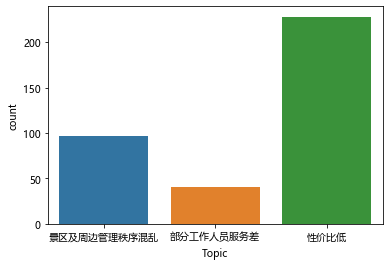

In [19]:
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
sns.countplot(df_dominant_topic['Topic'])

In [20]:
Attitude = []    
for i, v in df_dominant_topic['Text'].iteritems():
    s = SnowNLP(v)
    Attitude.append(s.sentiments)
df_dominant_topic['Attitude'] = Attitude

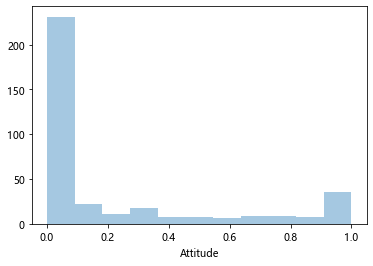

In [22]:
#所有主题的情感倾向分布情况
sns.distplot(df_dominant_topic['Attitude'],kde = False)

In [28]:
#对该主题下情感倾向大于0.8的评论进行分析
df_dominant_topic[df_dominant_topic['Attitude']>0.8]['Text']

9          演员都不错，就是剧里的那种突出男尊女卑，传宗接代等思想不太喜欢。尤其是最后还要特别强调一下
37     有种上当叫不信邪。号称每个展馆有免费讲解，进门第一个馆，讲解员用最快的语速差不多半分钟介绍完...
45                            还没有建完，很多还在施工，票价这么贵，根本不值得去。
60     到处都在大兴土木，很煞风景。居民太商业，丧失了淳朴！景色还不错，静谧的田园风光。溶洞神秘，新...
78        历经千辛万苦不远千里之遥来这里，结果很失望，没有了原生态的东西，景点缺少规划，望抓紧改正一下
90                          不要玩，不好玩，门票50一人，景色一般，没有什么可以看的
92     只有走马观花地看看，停靠的三个点没有什么看头，去了一个民居一人什么都不干就要十块钱，只适合拍...
133                                   没有什么特别的感觉，就像逛公园一样。
148             感觉很棒，到处都是俄罗斯建筑，风景很美，是一次难忘的愉快出行，下次还会再来，很好
154             很好，感觉很棒，这是一次愉快的出行，对园内的建筑感觉十分的喜爱与好奇，下次还会来
155                            说好的返现呢？说好的海参呢？以后再也不会相信了……
156                         伏尔加庄园景色很美，空气很好，玩的很开心，介绍朋友来玩。
164                             所有的冰上活动都没有了，为什么还开着园还要收门票
171                                  景色宜人，现在正式花期，有机会还要来！
173                                     很不好玩，所有的都很一般，没特色
179                                  没什么可看的、可参观的，园里葡萄刚发芽
207                           玩的挺高兴的，走的时候有点添堵，不知是哪个骚逼停的车
215                            

In [29]:
#情况1
df.iloc[171,]

Unnamed: 0                     6438
Unnamed: 0.1                   6438
name                    M36****6618
gender                       female
关注                                0
粉丝                                0
time                      2019/10/8
rating                   width:20%;
text            景色宜人，现在正式花期，有机会还要来！
useful                       有用 （0）
Name: 171, dtype: object

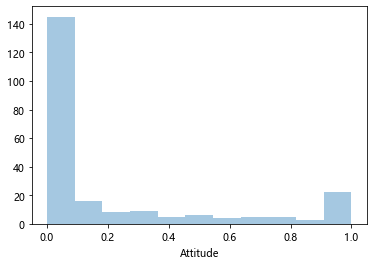

In [30]:
#某个主题的情感倾向分布情况-性价比低
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='性价比低']['Attitude'],kde = False)

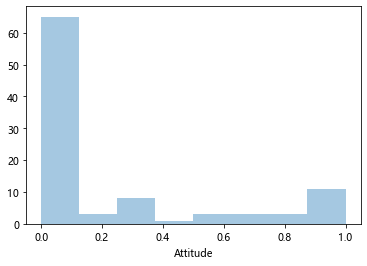

In [31]:
#某个主题的情感倾向分布情况-景区及周边管理秩序混乱
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='景区及周边管理秩序混乱']['Attitude'],kde = False)

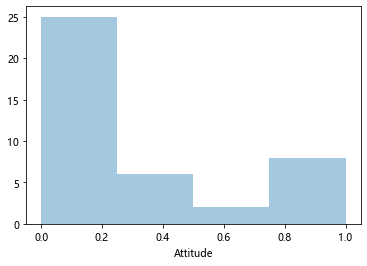

In [32]:
#某个主题的情感倾向分布情况-部分工作人员服务差
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='部分工作人员服务差']['Attitude'],kde = False)

In [34]:
#情况2
a = SnowNLP('集古城古镇于大全，超过了我原来心目中的丽江等，划过流淌的碧水，穿过古城的昨日。')
a.sentiments

0.018954295889539674

# 统计分析

In [35]:
df_gender_fans_sta = pd.merge(df,df_dominant_topic,left_on='text',right_on='Text',how='inner')[['gender','粉丝','text','Topic']]

In [36]:
df_gender_fans_sta.dropna(inplace = True)

In [37]:
df_gender_fans_sta.groupby(['Topic','gender']).count().T

Topic    性价比低      景区及周边管理秩序混乱      部分工作人员服务差     
gender female male      female male    female male
粉丝        116  112          46   51        20   21
text      116  112          46   51        20   21

In [38]:
index = df_gender_fans_sta['Topic'].value_counts(normalize = True, dropna = False).index
statistics = df_gender_fans_sta.groupby(['Topic','gender']).text.count().T.values.tolist()

female_count = df_gender_fans_sta[ df_gender_fans_sta['gender']=='female'].shape[0]   #男游客评论人数
male_count = df_gender_fans_sta[ df_gender_fans_sta['gender']=='male'].shape[0]       #女游客评论人数

a,b = [],[]
for i in range(len(statistics)):                                                      #标准化
    if i%2 ==0:
        a.append(statistics[i]/female_count)
    else:
        b.append(statistics[i]/male_count)
for i in range(len(a)):
    a[i],b[i] = a[i]/(a[i]+b[i]),b[i]/(a[i]+b[i])

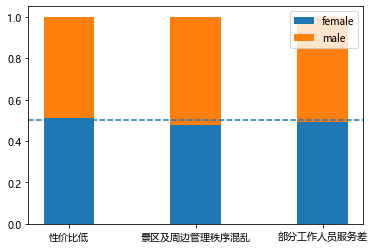

In [39]:
plt.bar(index, a, width=0.4, label='female')
plt.bar(index, b, width=0.4, bottom=a, label= 'male')
plt.axhline(y = 0.5,ls ='--')
plt.legend()
plt.show()

In [40]:
fans_sta = df_gender_fans_sta[df_gender_fans_sta['粉丝']>500].groupby('Topic').text.count()
fans_sta

Topic
性价比低           7
景区及周边管理秩序混乱    2
Name: text, dtype: int64

<BarContainer object of 2 artists>

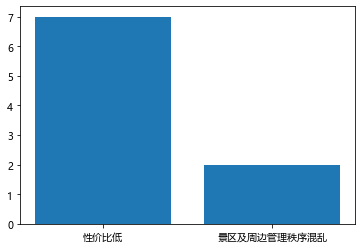

In [41]:
plt.bar(fans_sta.index,fans_sta.tolist())